In [1]:
import models_train
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn import metrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
index_path = 'index_Lthan10.csv'
list_use_target_head0 = list(pd.read_csv(index_path, index_col=0).iloc[:, 0].values)
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:

data_load = models_train.netdata('nature_ecfp4.csv', 
                    'nature_activity.csv', 
                   'nature_weightbymol.csv', index_path)
data_loader = DataLoader(data_load, batch_size=1024)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
index_path = 'index_Lthan10.csv'
model_pre = models_train.MLP(h_list=[2048,2048,1024], out_featrues=229)
model_pre.to(device)
model_pre = nn.DataParallel(model_pre) 
model_pre.load_state_dict(torch.load('models.pth'))


source


<All keys matched successfully>

In [ ]:
model_pre.eval()

## test data prediction

In [5]:
import math
from sklearn import metrics
test_file = pd.read_csv('refcompare_testfile.csv', index_col=0)
out_target_dic = list(pd.read_csv('target_overlap.csv', index_col=0).iloc[:, 1])
def predict(drug_smiles):
    np_out = model_pre(torch.tensor(np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(drug_smiles), 2, 2048))).unsqueeze(0))
    np_out = list(np_out.detach().cpu().numpy().squeeze())
    np_real = test_file.loc[drug_smiles, :]
    v_list = [i for i in range(len(np_out)) if np_out[i] > 0.5]
    r_list = [i for i in range(len(np_real)) if np_real[i] == 1]
    v_list = test_file.columns[v_list]
    r_list = test_file.columns[r_list]
    v_list = [i for i in v_list if i in out_target_dic]
    r_list = [i for i in r_list if i in out_target_dic]
    return v_list, r_list

def predicttop(drug_smiles, num=15):
    np_out = model_pre(torch.tensor(np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(drug_smiles), 2, 2048))).to(torch.device("cuda:1" if torch.cuda.is_available() else "cpu")).unsqueeze(0))
    np_out = list(np_out.detach().cpu().numpy().squeeze())
    
    target_index = []
    i = 0
    while i < num:
        if test_file.columns[np_out.index(max(np_out))] in out_target_dic:
            i += 1
            target_index.append(np_out.index(max(np_out)))
            np_out[np_out.index(max(np_out))] = 0
            toptargets = test_file.columns[target_index]
        else:
            np_out[np_out.index(max(np_out))] = 0

    np_real = test_file.loc[drug_smiles, :]
    r_list = [i for i in range(len(np_real)) if np_real[i] == 1]
    r_list = test_file.columns[r_list]
    r_list = [i for i in r_list if i in out_target_dic]
    return toptargets, r_list


In [6]:
predict_result = []
activity = []
all_toptargets = []
drug_smiles = []
for i in list(test_file.index):
    if len(predict(i)[1]) > 0:
        predict_result.append(predict(i)[0])
        activity.append(predict(i)[1])
        all_toptargets.append(predicttop(i, num=15)[0])

In [7]:
def accuracy(real, vis):
    if len(real) > 0:
        return len([i for i in real if i in vis]) / len(real)
    else:
        return None

def accuracy_top(real, tops):
    if len(real) > 0:
        if len([i for i in tops if i in real]) > 0:
            return 1
        else:
            return 0
    else:
        return None

In [8]:
all_accuracy_predict = []
for i in range(len(activity)):
    if accuracy(activity[i], predict_result[i]) is not None:
        all_accuracy_predict.append(accuracy(activity[i], predict_result[i]))

all_accuracy_top = []
for i in range(len(activity)):
    if accuracy_top(activity[i], all_toptargets[i]) is not None:
        all_accuracy_top.append(accuracy_top(activity[i], all_toptargets[i]))

## AUROC

In [13]:
out_target_dic = pd.read_csv('target_overlap.csv', index_col=0)
def target_trans(df):
    new_df = pd.DataFrame(index= df.index, columns = list(out_target_dic.iloc[:, 1]))
    for i in range(new_df.shape[1]):
        trans_ind = list(df.columns).index(new_df.columns[i])
        new_df.iloc[:, i] = df.iloc[:, trans_ind]
    return new_df

In [14]:
test_result = pd.DataFrame(index=test_file.index, columns=test_file.columns)
for i in list(test_file.index):
    np_out = model_pre(torch.tensor(np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i), 2, 2048))).unsqueeze(0))
    np_out = list(np_out.detach().cpu().numpy().squeeze())
    test_result.loc[i, :] = np_out

In [16]:
test_result = target_trans(test_result)
test_real = target_trans(test_file)

In [18]:
from sklearn import metrics
def AUROC(test_label, test_output):
    fpr, tpr, _ = metrics.roc_curve(np.array(test_label).flatten(), np.array(test_output).flatten(),  pos_label=1 )
    return metrics.auc(fpr, tpr)
def SE(test_label, test_output, cut=0.5):
    test_label = np.array(test_label).flatten()
    test_output = np.array(test_output).flatten()
    test_label = list(test_label > cut)
    test_output = list(test_output > cut)
    test_label = [i for i in range(len(test_label)) if test_label[i] == True]
    test_output = [i for i in range(len(test_output)) if test_output[i] == True]
    tp = len([i for i in test_output if i in test_label])
    fp = len([i for i in test_output if i not in test_label])
    fn = len(test_label) - tp
    return tp / (tp + fn)

In [19]:
AUROC(test_real, test_result)

0.9101974520041801

In [40]:
cut_cache = [i for i in np.arange(0.99, 0.00, -0.01)]
SE_cache = []
for cut_e in cut_cache:
    SE_cache.append(SE(test_real, test_result, cut=cut_e))

In [37]:
import pickle
f = open('SE_starfish.pkl', 'rb')
SE_starfish = pickle.load(f)
f.close()


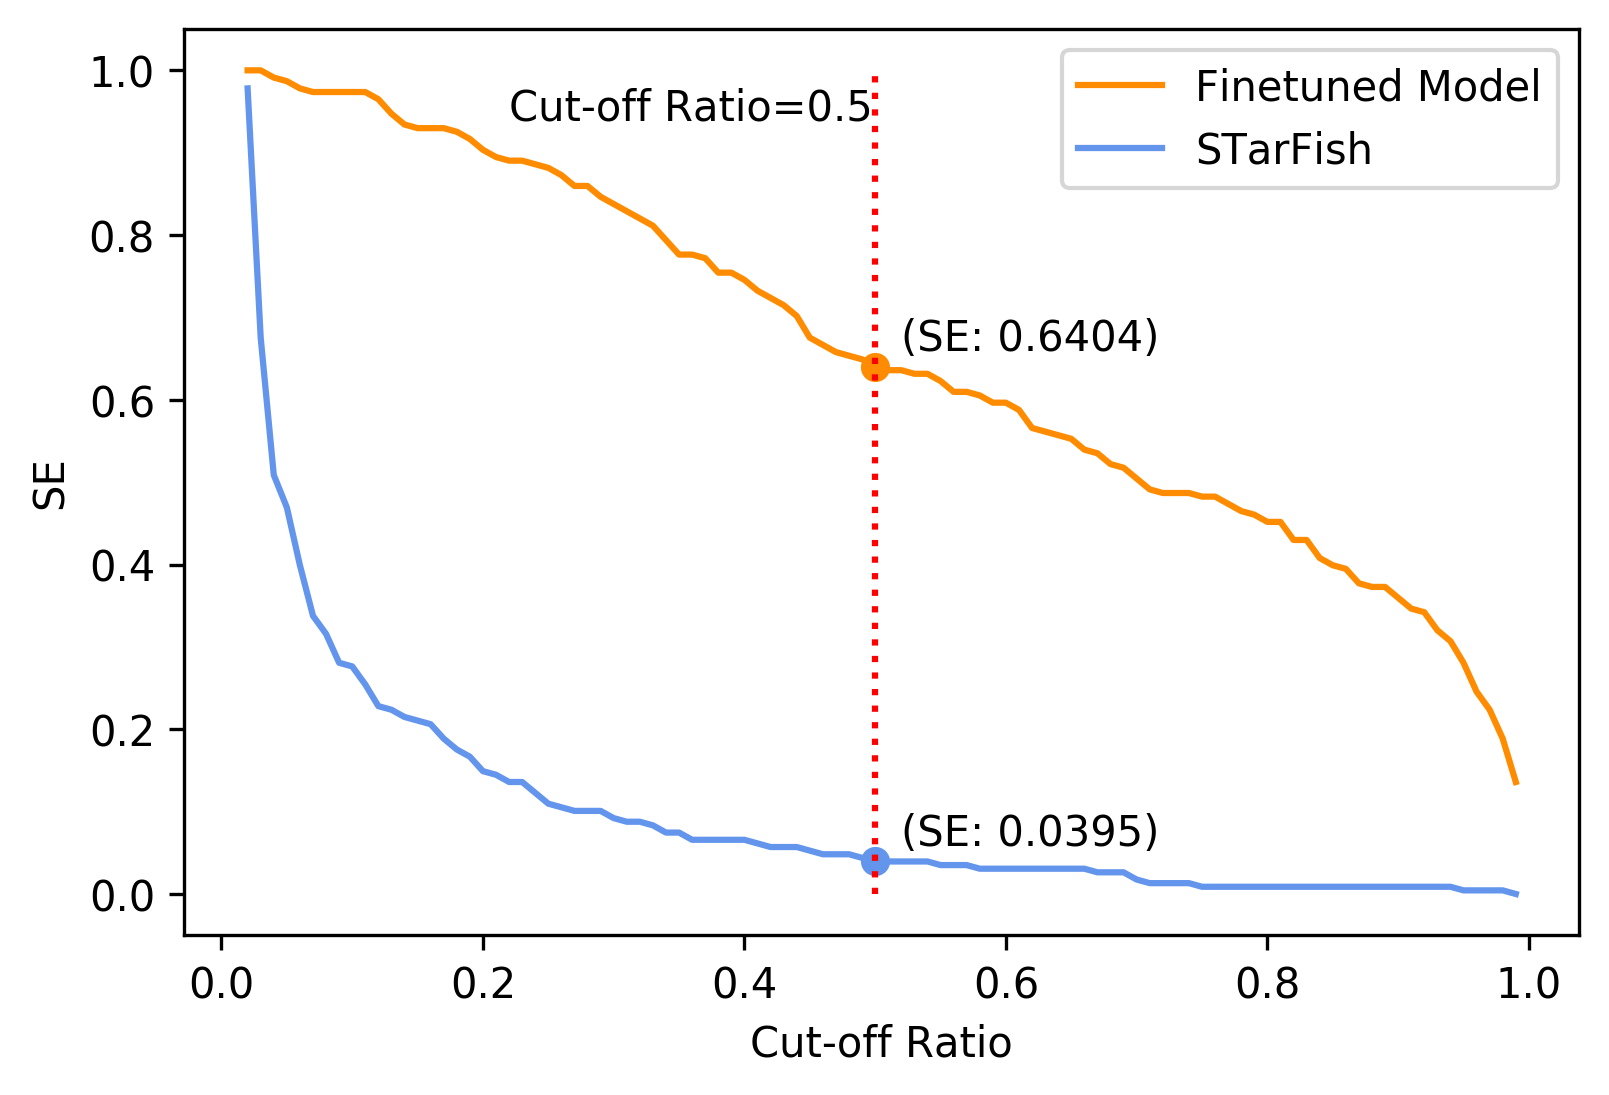

In [76]:
import matplotlib.pyplot as plt
x = [i for i in np.arange(0.99, 0.01, -0.01)]
ax1 = plt.figure(dpi=300)
ax = ax1.subplots(1,1)
ax.plot(x, SE_cache[:-1], label='Finetuned Model', color='darkorange')
ax.plot(x, SE_starfish[:-1], label='STarFish', color='cornflowerblue')
#ax.invert_xaxis()
#ax.plot(x, SE_starfish, 'ro-', x, SE_cache, 'b^-')
ax.legend()
plt.scatter([0.5,], [0.6403509, ], color='darkorange')
plt.scatter([0.5,], [0.0394737, ],  color='cornflowerblue')
plt.text(0.22, 0.94, 'Cut-off Ratio=0.5')
plt.text(0.52, 0.6603509, '(SE: 0.6404)')
plt.text(0.52, 0.0594737, '(SE: 0.0395)')

Y_base = np.linspace(0,1,12)
X_base = np.ones(Y_base.size)
ax.plot( (0.5) * X_base, Y_base, linestyle=':', color='red')
plt.xlabel('Cut-off Ratio')
plt.ylabel('SE')
plt.show()